# SHP2CSV algorithm
## Importing libraries

In [18]:
from shapely.geometry import shape
from shapely.ops import unary_union
import fiona
import networkx as nx
import itertools
import matplotlib.pyplot as plt
from IPython.core.debugger import Tracer
from shutil import copyfile

## Importing and reading shp file

In [2]:
geoms =[shape(feature['geometry']) for feature in fiona.open("shp/Bogota_linea/Bogota_linea_holes/Bogota_linea.shp") if feature['geometry'] != None]


## Converting `geoms` into a planar graph

In [3]:
file_info = fiona.open("shp/Bogota_linea/Bogota_linea_holes/Bogota_linea.shp")

In [4]:
highways_raw = [item['geometry']['coordinates'] for item in file_info if item['geometry'] != None and item ['properties']['Id']==2]

In [5]:
res = unary_union(geoms)

## Creating a Graph object in order to print it
this part of the code is not needed, it is just for having an idea of the graph that is going to be exported

In [6]:
G = nx.Graph()
for line in res:
    for seg_start, seg_end in zip(list(line.coords),list(line.coords)[1:]):
        G.add_edge(seg_start, seg_end)

## Plotting the graph

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is dep

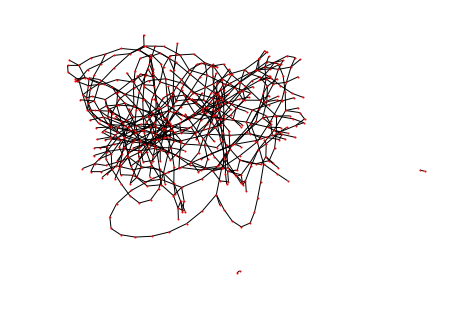

In [7]:
nx.draw(G, node_size=1)
plt.show()

## Creating sets

In [7]:
y = set()
x = set()
lengths = set()

nodes = set()
edges = set()

nodes_norm = list()
edges_norm = set()

## Creating a list of nodes

In [8]:
for line in res:
    for node in line.coords:
        nodes.add(node)
        x.add(node[0])
        y.add(node[1])

nodes = list(nodes)

## Normalizing the nodes coordinates

In [9]:
# Getting the max and min for x and y axis
x_max = max(x)
x_min = min(x)
y_max = max(y)
y_min = min(y)

In [10]:
df3 = pd.DataFrame(data=[[x_min,x_max,y_min,y_max]], columns=['x_min','x_max','y_min','y_max'])
df3.to_csv('../../distributions/boundaries.csv', index=False)

In [11]:
# Normalizing

highways = []
for highway in highways_raw:
    highways.append(list(zip([(x-x_min)/(x_max-x_min) for x in list(zip(*highway))[0]],[(y-y_min)/(y_max-y_min) for y in list(zip(*highway))[1]])))

for node in nodes:
    node_norm = (nodes.index(node), [(node[0]-x_min)/(x_max-x_min),(node[1]-y_min)/(y_max-y_min)])
    nodes_norm.append(node_norm)

In [12]:
nodes_norm

[(0, [0.30041723955230076, 0.5014327458237]),
 (1, [0.45697423420969996, 0.69429616153067]),
 (2, [0.9623530190548829, 0.9664937217798706]),
 (3, [0.8686780669621242, 0.9597169367853491]),
 (4, [0.20220678408480466, 0.36853093192452024]),
 (5, [0.6145956920344726, 0.9609249172665623]),
 (6, [0.2692806679215398, 0.34210800332579394]),
 (7, [0.7200045083275557, 0.37253583954671216]),
 (8, [0.4338873772316727, 0.299488651765529]),
 (9, [0.4868780669235709, 0.6102090641325038]),
 (10, [0.42695699552446786, 0.388760394639172]),
 (11, [0.5350925025738033, 0.3124927149523625]),
 (12, [0.37196729416452995, 0.5551522037452311]),
 (13, [0.4937514252801483, 0.6680926771635353]),
 (14, [0.3199604489626283, 0.6047472645713482]),
 (15, [0.41330911757430855, 0.6742560701095325]),
 (16, [0.4295699624685504, 0.7138210120356242]),
 (17, [0.5728524194563629, 0.5658487977135848]),
 (18, [0.6787857191341383, 0.7183246462483636]),
 (19, [0.8549730661859655, 0.6907046605163073]),
 (20, [0.9997131091070505, 0

## Creating a list of edges

In [13]:
'''
the old way
for line in res:
    #Tracer()()
    last_coord = None
    lenght = len(line.coords)
    for coord in line.coords:
        if last_coord != None:
            edge = (nodes.index(last_coord),nodes.index(coord),line.length/lenght)
            lengths.add(line.length/lenght) #modify this
            edges.add(edge)
        last_coord = coord
        
    
edges = list(edges)'''

'\nthe old way\nfor line in res:\n    #Tracer()()\n    last_coord = None\n    lenght = len(line.coords)\n    for coord in line.coords:\n        if last_coord != None:\n            edge = (nodes.index(last_coord),nodes.index(coord),line.length/lenght)\n            lengths.add(line.length/lenght) #modify this\n            edges.add(edge)\n        last_coord = coord\n        \n    \nedges = list(edges)'

In [14]:
for line in file_info:
    #Tracer()()
    last_coord = None
    for coord in line['geometry']['coordinates']:
        if last_coord != None:
            length = ((coord[0]-last_coord[0])**2+(coord[1]-last_coord[1])**2)**0.5
            edge = (nodes.index(last_coord),nodes.index(coord),length,line['properties']['Id'])
            edges.add(edge)
        last_coord = coord
        
    
edges = list(edges)

## Normalizing the cost of the edges

In [15]:
length_max = max(list(zip(*edges))[2])
length_min = min(list(zip(*edges))[2])

# normalizing length
edges_norm = [(edges.index(edge),edge[0],edge[1],(edge[2]-length_min)/(length_max-length_min),edge[3]) for edge in edges]

## printing results

In [16]:
nodes_norm

[(0, [0.30041723955230076, 0.5014327458237]),
 (1, [0.45697423420969996, 0.69429616153067]),
 (2, [0.9623530190548829, 0.9664937217798706]),
 (3, [0.8686780669621242, 0.9597169367853491]),
 (4, [0.20220678408480466, 0.36853093192452024]),
 (5, [0.6145956920344726, 0.9609249172665623]),
 (6, [0.2692806679215398, 0.34210800332579394]),
 (7, [0.7200045083275557, 0.37253583954671216]),
 (8, [0.4338873772316727, 0.299488651765529]),
 (9, [0.4868780669235709, 0.6102090641325038]),
 (10, [0.42695699552446786, 0.388760394639172]),
 (11, [0.5350925025738033, 0.3124927149523625]),
 (12, [0.37196729416452995, 0.5551522037452311]),
 (13, [0.4937514252801483, 0.6680926771635353]),
 (14, [0.3199604489626283, 0.6047472645713482]),
 (15, [0.41330911757430855, 0.6742560701095325]),
 (16, [0.4295699624685504, 0.7138210120356242]),
 (17, [0.5728524194563629, 0.5658487977135848]),
 (18, [0.6787857191341383, 0.7183246462483636]),
 (19, [0.8549730661859655, 0.6907046605163073]),
 (20, [0.9997131091070505, 0

In [17]:
edges_norm

[(0, 60, 431, 0.10440825393089288, 1),
 (1, 140, 313, 0.08359117462578074, 1),
 (2, 540, 108, 0.014904646554326903, 1),
 (3, 535, 266, 0.1057534176254246, 2),
 (4, 16, 589, 0.06820197671175095, 1),
 (5, 101, 479, 0.11110805851496358, 1),
 (6, 106, 367, 0.03232672405022162, 2),
 (7, 471, 535, 0.2770306231417267, 2),
 (8, 264, 578, 0.10441658554415857, 1),
 (9, 297, 283, 0.1480827682742998, 1),
 (10, 316, 143, 0.04607199789764318, 2),
 (11, 244, 197, 0.3494377959376718, 2),
 (12, 5, 36, 0.1398189993924071, 2),
 (13, 58, 524, 0.04171675466083531, 2),
 (14, 49, 449, 0.10896692508499248, 2),
 (15, 11, 448, 0.13413237991738153, 0),
 (16, 178, 345, 0.00717382384973812, 2),
 (17, 390, 185, 0.02488109782242239, 2),
 (18, 277, 229, 0.14770873267576684, 2),
 (19, 581, 135, 0.01662267139284622, 2),
 (20, 105, 548, 0.19323148374190072, 0),
 (21, 329, 473, 0.0016874941316241765, 1),
 (22, 109, 251, 0.013797751097028228, 1),
 (23, 298, 178, 0.006336130687018646, 2),
 (24, 508, 461, 0.1056164880236124

## Exporting results to csv

In [22]:
# Writing csv
import csv

# vertices
with open("vertices.csv", "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in nodes_norm:
        writer.writerow([val[0],val[1][0],val[1][1]])
        
# edges
with open("edges.csv", "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in edges_norm:
        writer.writerow(val)

copyfile('edges.csv', '../../streets/edges.csv');
copyfile('vertices.csv', '../../streets/vertices.csv');